In [1]:
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np
import folium
import datetime as dt
import os

%matplotlib inline
# sns.set_context('notebook')

path = '/'.join(os.getcwd().split('/')[:-1])
print(path)

tci = pd.read_csv(path+'/data/model_data/tci_1_0.csv', parse_dates=['Date'], dtype={'PIN': str})
cols = ['parcel','vacant','Date','Survey Category','Survey Grade','SPA_NAME']
tci = tci[cols]
tci.shape 

/Volumes/Dropbox/largetransfer/luc/carter


(113132, 6)

In [2]:
tem = tci[['SPA_NAME','vacant']].groupby('SPA_NAME').agg([sum,len])
t = pd.Series(tem['vacant']['sum']/tem['vacant']['len']).reset_index()
t = t.rename(columns={0:'rate'})

,SPA_NAME,geometry
0,Bellaire-Puritas,"POLYGON ((-81.768698 41.445354, -81.769142 41...."
1,Broadway-Slavic Village,"POLYGON ((-81.615144 41.438055, -81.615167 41...."
2,Brooklyn Centre,"POLYGON ((-81.682303 41.448981, -81.682704 41...."
3,Buckeye-Shaker Square,"POLYGON ((-81.58451700000001 41.47909, -81.584..."
4,Buckeye-Woodhill,"POLYGON ((-81.601463 41.493458, -81.601502 41...."
5,Central,"POLYGON ((-81.63641 41.486724, -81.63641 41.48..."
6,Clark-Fulton,"POLYGON ((-81.698986 41.477295, -81.6990080000..."
7,Collinwood-Nottingham,"POLYGON ((-81.536017 41.572854, -81.5384849999..."
8,Cudell,"POLYGON ((-81.742772 41.469947, -81.7457590000..."
10,Detroit Shoreway,"POLYGON ((-81.71768299999999 41.488343, -81.71..."


In [67]:
import geopandas as gp
geo = gp.GeoDataFrame.from_file(path+'/data/shapefiles/City_of_Cleveland_Neighborhoods_2012_no_lake.shp')
with open(path+'/data/shapefiles/test.geojson', 'w') as f:
    f.write(geo[~geo.SPA_NAME.isin(['Hopkins','Cuyahoga Valley'])].to_json())
# >>>boros.set_index('BoroCode', inplace=True)
# geo = pd.merge(geo, t, left_on='SPA_NAME', right_index=True, how='left', copy=False)

In [68]:
state_geo = path+'/data/shapefiles/test.geojson'

#Let Folium determine the scale
mp = folium.Map(location=[41.5, -81.7], zoom_start=11,\
                tiles=None)
                
# mp = folium.Map(location=[41.5, -81.7], zoom_start=11,\
#                 attr='Mapbox',\
#                 API_key='pk.eyJ1IjoiY3dhbmc5MTIiLCJhIjoib1NKZUpiVSJ9.LciLaObuYaFzC0t-kTR6lg',\
#                 tiles='http://api.tiles.mapbox.com/v3/cwang912.he3f677p/3/1/1.png')
mp.choropleth(geo_path=state_geo, data=t,
                threshold_scale=[0,0.05,0.1,0.15,0.2, 0.25],
             columns=['SPA_NAME', 'rate'],
             key_on='feature.properties.SPA_NAME',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Vacancy Rate(%)')
# mp.save(path='mapbox_bright.html')
mp

In [80]:
mp.save(path+'/data/shapefiles/map.html')

In [76]:
folium.write_png(path+'/data/shapefiles/map.png')

AttributeError: 'module' object has no attribute 'write_png'

In [34]:
dates = dict(zip(tci.parcel, tci.Date))

In [35]:
pv = pd.read_csv(path+'/data/clean_data/postal_vacancy.csv', parse_dates=3, index_col=0)
pv.date = pv.date.apply(lambda x: dt.datetime(int(x[0:4]),int(x[5:7]),int(x[8:10])))
pv = pv.sort_values('date',ascending=False)
pv = pv.loc[pv.apply(lambda x: x.date < dates[x.PARCEL], axis=1)]

# count the number of consecutive times a parcel is postal vacant, working backwards
def fun(x):
    total = 0
    recent = pv_dates[pv_dates<dates[x.parcel]]

    for i,j in enumerate(x[recent]):
        if x[recent][-i-1] == 'Y':
            total += 1
        else:
            return total
    return total

pv_dates = pv.groupby('date').last().index
pv2 = pv.pivot(index='PARCEL',columns='date').fillna('N').reset_index()
pv2.columns = pv2.columns.droplevel()
pv2.columns.values[0] = 'parcel'
pv2['pv_count'] = pv2.apply(fun, axis=1)
pv2 = pv2.set_index('parcel')

In [50]:
tci = pd.merge(tci,pv2[['pv_count']], left_on='parcel',right_index=True, how='left')


In [51]:
tci.head()

,parcel,vacant,Date,Survey Category,Survey Grade,SPA_NAME,pv_count
0,001-01-001,0,2015-08-10 15:05:00,Occupied Structure,A,Edgewater,NaN
1,001-01-003,0,2015-08-10 15:09:00,Occupied Structure,A,Edgewater,NaN
2,001-01-004,0,2015-08-10 15:06:00,Occupied Structure,A,Edgewater,NaN
3,001-01-005,0,2015-08-10 15:07:00,Occupied Structure,B,Edgewater,NaN
4,001-01-006,0,2015-08-10 15:10:00,Occupied Structure,A,Edgewater,NaN


In [54]:
tci['postal_vacant'] = tci.apply(lambda x: 1 if x.pv_count > 0 else 0, axis=1)

In [55]:
tci.head()

,parcel,vacant,Date,Survey Category,Survey Grade,SPA_NAME,pv_count,postal_vacant
0,001-01-001,0,2015-08-10 15:05:00,Occupied Structure,A,Edgewater,NaN,0
1,001-01-003,0,2015-08-10 15:09:00,Occupied Structure,A,Edgewater,NaN,0
2,001-01-004,0,2015-08-10 15:06:00,Occupied Structure,A,Edgewater,NaN,0
3,001-01-005,0,2015-08-10 15:07:00,Occupied Structure,B,Edgewater,NaN,0
4,001-01-006,0,2015-08-10 15:10:00,Occupied Structure,A,Edgewater,NaN,0


In [57]:
tem = tci[['SPA_NAME','postal_vacant']].groupby('SPA_NAME').agg([sum,len])
t2 = pd.Series(tem['postal_vacant']['sum']/tem['postal_vacant']['len']).reset_index()
t2 = t2.rename(columns={0:'postal_rate'})

In [69]:
state_geo = path+'/data/shapefiles/test.geojson'

#Let Folium determine the scale
mp = folium.Map(location=[41.5, -81.7], zoom_start=11,\
                tiles=None)
                
# mp = folium.Map(location=[41.5, -81.7], zoom_start=11,\
#                 attr='Mapbox',\
#                 API_key='pk.eyJ1IjoiY3dhbmc5MTIiLCJhIjoib1NKZUpiVSJ9.LciLaObuYaFzC0t-kTR6lg',\
#                 tiles='http://api.tiles.mapbox.com/v3/cwang912.he3f677p/3/1/1.png')
mp.choropleth(geo_path=state_geo, data=t2,
                threshold_scale=[0,0.05,0.1,0.15,0.2, 0.25],
             columns=['SPA_NAME', 'postal_rate'],
             key_on='feature.properties.SPA_NAME',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Vacancy Rate(%)')
# mp.save(path='mapbox_bright.html')
mp

In [3]:
preds = pd.read_csv(path+'/data/predictions/xgb.csv', index_col=0)

In [4]:
xgb = pd.merge(preds, tci, left_index=True, right_on='parcel',how='left')

In [5]:
tem = xgb[['SPA_NAME','preds']].groupby('SPA_NAME').agg([sum,len])
t3 = pd.Series(tem['preds']['sum']/tem['preds']['len']).reset_index()
t3 = t3.rename(columns={0:'pred_rate'})

In [6]:
state_geo = path+'/data/shapefiles/test.geojson'

#Let Folium determine the scale
mp = folium.Map(location=[41.5, -81.7], zoom_start=11,\
                tiles=None)
                
# mp = folium.Map(location=[41.5, -81.7], zoom_start=11,\
#                 attr='Mapbox',\
#                 API_key='pk.eyJ1IjoiY3dhbmc5MTIiLCJhIjoib1NKZUpiVSJ9.LciLaObuYaFzC0t-kTR6lg',\
#                 tiles='http://api.tiles.mapbox.com/v3/cwang912.he3f677p/3/1/1.png')
mp.choropleth(geo_path=state_geo, data=t3,
                threshold_scale=[0,0.05,0.1,0.15,0.2, 0.25],
             columns=['SPA_NAME', 'pred_rate'],
             key_on='feature.properties.SPA_NAME',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Vacancy Rate (%)')
# mp.save(path='mapbox_bright.html')
mp

In [2]:
prop = pd.read_csv(path+'/data/clean_data/main_prop_filtered.csv')
prop = prop.drop_duplicates()
prop = prop.groupby('parcel').last()

In [5]:
tci = pd.merge(tci, prop[['LATITUDE','LONGITUDE']], left_on='parcel', right_index=True, how='left')

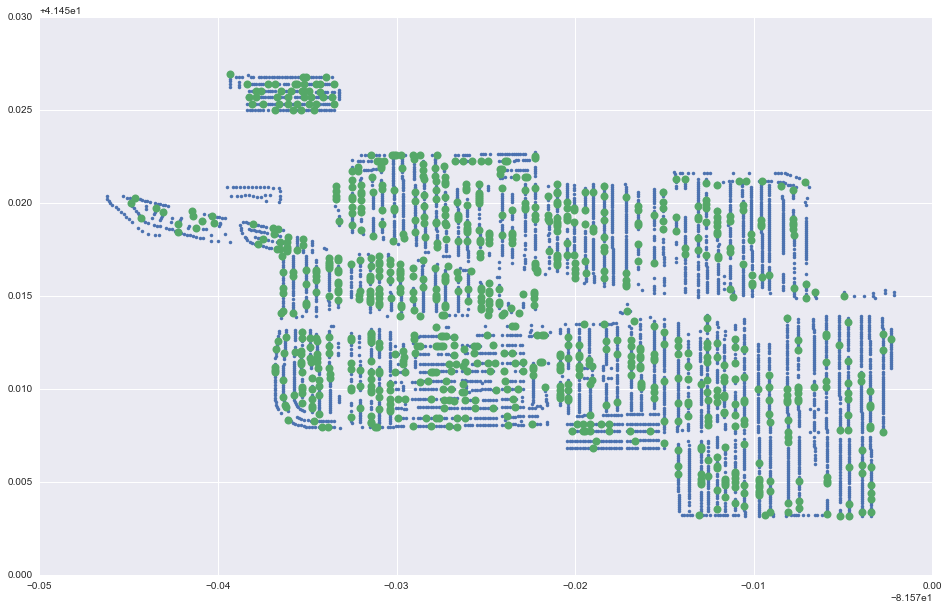

In [20]:
fig = plt.figure(figsize=[16,10])
plt.plot(tci[(tci.SPA_NAME=='Mount Pleasant')].LONGITUDE,tci[(tci.SPA_NAME=='Mount Pleasant')].LATITUDE,'.');
plt.plot(tci[(tci.vacant==1) & (tci.SPA_NAME=='Mount Pleasant')].LONGITUDE,tci[(tci.vacant==1) & (tci.SPA_NAME=='Mount Pleasant')].LATITUDE,'.',markersize=16);


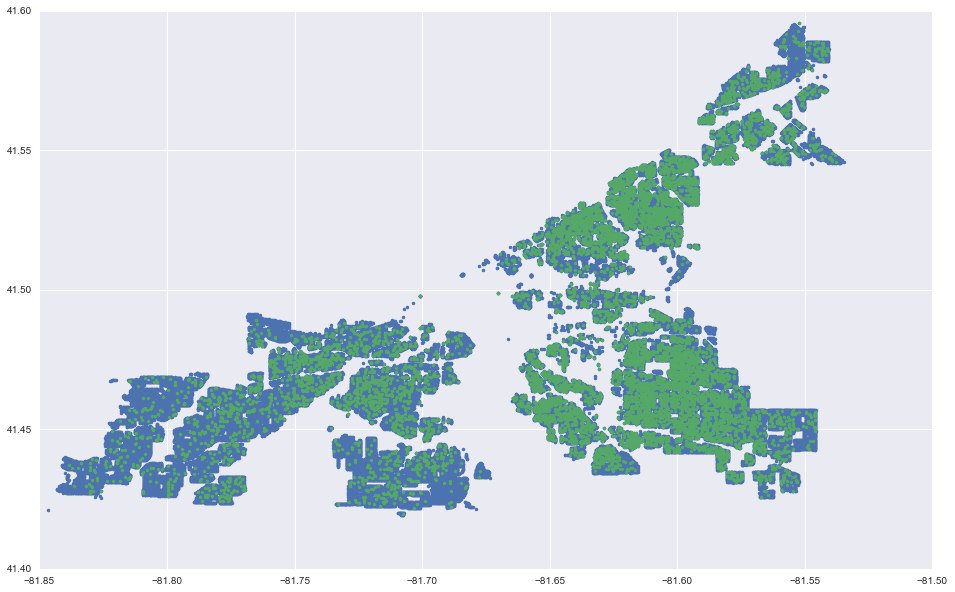

In [13]:
fig = plt.figure(figsize=[16,10])
plt.plot(tci.LONGITUDE,tci.LATITUDE,'.');
plt.plot(tci[tci.vacant==1].LONGITUDE,tci[tci.vacant==1].LATITUDE,'.');